# Calibration notebook
Notebook to quickly calibrate a set of data

In [5]:
%%file SEIS_calib_data.py
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed May 11 16:21:00 2022

@author: Gregory Sainton
@mail: sainton@ipgp.fr
@purpose: Programme to calibrate SEIS data -> This code is attached to the notebook
            NB_Data_Calibration.ipynb
@version: 1.0 - Plain version - This is compilation of cells from
                a notebook.

@TODO: - Put parameters into a config file
       - Add option to save figures
       
"""

import os
import sys
import warnings
from copy import deepcopy

import pandas as pd
import datetime as dt
import numpy as np 

# OBSPY Libraries
from obspy import UTCDateTime, read
from obspy.signal.util import next_pow_2
from obspy import read_inventory

# Internal useful functions
from modules.calibration import hack_VBB_Pos_FIR_gain_2_one
from modules.core.aspic_channel import read_csv_panda
from modules.core.utils.misc import *
from modules.plot.aspic_plot import *
from modules.rotation.rotation import *
from modules.ticknoiseremoval.Tick_Noise_Removal import *
from modules.spectro.spectro_func import *

warnings.filterwarnings('ignore')

# ----------------------
# Location of the data
# ----------------------

# COPY HERE THE PATH OF THE FILE
path_dir = "/Users/greg/Dropbox (IPGP)/Deglitched_data_by_Scholz/"
sol_dir  = "Sol1222"
# COPY HERE THE FILENAME
mseed_file = "VBB_UVW_2_scholz_prg_deglitched_sol_1222.mseed"
path_2_time_series = os.path.join(path_dir, sol_dir, mseed_file)

# COPY HERE THE PATH OF THE DATALESS
dataless_file = "dataless.XB.ELYSE.seed"
path_2_dataless = os.path.join(path_dir, dataless_file)

channels = "BH?"
location = "02"

# Calibration parameters
# -------------------------

## Trim
trim_data = True
startime_trim = "2022-05-04T23:00:00"
endtime_trim = "2022-05-05T01:00:00"

## Detick
detick_data = True

## Detrend
detrend_data = True

## Filter
filter_data = False
taperMargin = 0.05
fHigh = 0.001
fLow = 10
## Calibration
calib_data = True
pre_filt   = [0.009, 0.01, 9., 10.]
waterlevel = 145
output     = "VEL"  # (can take value 'ACC', 'DISP', 'VEL')

# Rotation to ZNE
rotate_data = True

# Save calibrated MSEED
save_calibred = True
calibrated_filename = mseed_file.replace(".mseed", "_calib.mseed")

# Plot options
plot_type="subplot" # "subplot" or "overplot"
plot_decim_factor = 10
plot_raw = True
plot_calib_data = True
plot_rotated = True
plot_spectro = True
plot_psd = True

# Memory
free_intermediate = True

# Verbosity
verbose = False

# Channel properties file (better not to change)
# --------------------------
CHANNEL_PROPERTIES_FILE = "./configuration/channel.properties2.0.csv"
units_dict = {"DISP": r"$m$", "VEL":r"$m.s^{-1}$", "ACC": r"$m.s^{-2}$"}
## INPUT DATA PART
# ----------------

if os.path.exists(CHANNEL_PROPERTIES_FILE):
    pass
else:
    sys.exit("Config file not found")

DF_PROPERTIES  = pd.read_csv(CHANNEL_PROPERTIES_FILE, delimiter=";")
if verbose:
    print(40*"-.")
    print("Data are located at here: ")
    print("\t- Time series : {}".format(path_2_time_series))
    print("\t- Dataless : {}".format(path_2_dataless))
    print(40*"-."+"\n\n")

    # Open the file with obspy
    print("Content of the file: ")
try:
    if verbose:
        print(path_2_time_series)
    traces = read(path_2_time_series)#function 'read', to open the mseed file. Data are stored in a Stream object, made of Traces

except FileNotFoundError:
    sys.exit("Oups, file does not exist or path to the file is wrong")

# Subsample of the whole set of traces if needed
if channels is not None and location is not None:
    channelBH = traces.select(channel=channels,
                          location=location) # Here is a way to select only Vel data of the 3 VBBs
else:
    channelBH = traces

if verbose:
    print(channelBH)

if free_intermediate:
    del(traces)

if trim_data: 
    if verbose:
        print("Trim of the data requested:")
    channelBH.trim(UTCDateTime(startime_trim), UTCDateTime(endtime_trim))
    if verbose:
        print(f"\t-> Trim done between {startime_trim} and {endtime_trim} UTC")
        print(40*"-."+"\n\n")

# Plot the raw data if requested
if plot_raw:
    plot_channels_v2(channelBH, typeplot=plot_type,
                     xunits="UTC",
                     decim=plot_decim_factor, 
                    title= "SOL 1022 (raw)")

# --------------------------------------
# Calibration part
# --------------------------------------
if verbose:
    print(40*"-.")
    print("Calibration started")

# Detick the data according to Nicolas Compaire's code
if detick_data:
    if verbose:
        print("Detick @ 1Hz requested:")
    channelBH_detick = channelBH.copy()
    try:
        channelBH_detick = detick_noise_02_BH_stream(channelBH)
        
    except:
        sys.exit("Error during deticking")
    else:
        if verbose:
            print("\t-> Detick done...")
        else:
            pass

# Detrend
channelBH_det = channelBH_detick.copy()
if free_intermediate:
    del(channelBH_detick)
if detrend_data:
    if verbose:
        print("Detrend requested:")
    try:
        channelBH_det.detrend(type='spline', order=2, 
                              dspline=2000, plot=False)
    except:
        sys.exit("Error in detrending step.")
    else:
        if verbose:
            print("\t-> Detrend done...")
        else:
            pass
# Filter
channelBH_det_filter = channelBH_det.copy()
if free_intermediate:
    del(channelBH_det)
if filter_data:
    if verbose:
        print("Filtering requested:")
    try:
        channelBH_det_filter.taper(type="cosine", max_percentage=taperMargin)
        channelBH_det_filter.filter('highpass', freq=fHigh, corners=5, zerophase=True)
        channelBH_det_filter.taper(type="cosine", max_percentage=taperMargin)
        channelBH_det_filter.filter('lowpass', freq=fLow, corners=5, zerophase=True)
        
    except:
        sys.exit("Error in detrending step.")
    else:
        if verbose:
            print("-> Filter done...")
        else:
            pass

# Calibration
if verbose:
    print("Calibration requested:")
channelBH_det_filt_calib = channelBH_det_filter.copy()
if free_intermediate:
    del(channelBH_det_filter)
if calib_data: 
    try:
        inv = read_inventory(path_2_dataless)

    except FileNotFoundError:
        sys.exit("Oups, impossible to open the dataless file -> please check !")
    else:
        channelBH_det_filt_calib.remove_response(inventory=inv, output=output,
                                                water_level=waterlevel, plot=False)
        if verbose:
            print(f"\tResponse removed -> Data are now in {units_dict.get(output)}\n\n")

    if plot_calib_data:
        plot_channels_v2(channelBH_det_filt_calib, typeplot=plot_type,
                         xunits = "UTC", yunits=units_dict.get(output),
                         decim=plot_decim_factor, 
                         title= f"SOL 1022 calibrated in {units_dict.get(output)}")

# Rotation
# --------
# If your times series are not synchronised (at least with the same starttime, 
# same end time and the same sampling rate), the rotation from instruments axes 
# UVW to geographical coordinates NEZ is impossible.
channelBH_det_filt_calib_rotated = channelBH_det_filt_calib.copy()
if free_intermediate:
    del(channelBH_det_filt_calib)
if rotate_data: 
    if verbose:
        print("Rotation requested:")
    
    try:
        channelBH_det_filt_calib_rotated.rotate(method="->ZNE", 
                                                inventory=inv)
        
        for cha in channelBH_det_filt_calib_rotated:
            if cha.stats.channel[2] == "U":
                 cha.stats.channel = cha.stats.channel[:2]+"Z"
            if cha.stats.channel[2] == "V":
                cha.stats.channel = cha.stats.channel[:2]+"N"
            if cha.stats.channel[2] == "W":
                cha.stats.channel = cha.stats.channel[:2]+"E"
        if verbose:
            print(channelBH_det_filt_calib_rotated)
            print("-> Rotation to ZNE done...")
        if plot_rotated:
            plot_channels_v2(channelBH_det_filt_calib_rotated,
                             typeplot=plot_type,
                             xunits = "UTC", yunits=units_dict.get(output),
                             decim=plot_decim_factor,
                             title= f"SOL 1022 calibrated in {units_dict.get(output)} in ZNE")
    except:
        sys.exit("Error during rotation process")

if verbose:
    print(40*"-."+"\n\n")
if save_calibred:
    outfile = os.path.join(path_dir,sol_dir, calibrated_filename)
    channelBH_det_filt_calib_rotated.write(outfile, format='MSEED')
    if verbose:
        print(f"-> Calibrated data saved in {outfile}")

        

if plot_spectro:
    if verbose:
        print("\nSpectrogram requested: \n")
    for chan in channelBH_det_filt_calib_rotated:
        spectro_from_trace(chan, wlen=2000, \
                    per_lap=0.9, mult = 8, fmin=0.01, fmax=10,\
                    vmin_param=-200, vmax_param=-140, \
                    xunits = "LSMT", yunits=units_dict.get(output))
    
if plot_psd:
    if verbose:
        print("\nPSD requested: \n")
    create_freq_plot(channelBH_det_filt_calib_rotated,
                     freq_choice = "PSD", typeplot = plot_type, 
                     xunits = "Hz", yunits=units_dict.get(output))


Overwriting SEIS_calib_data.py


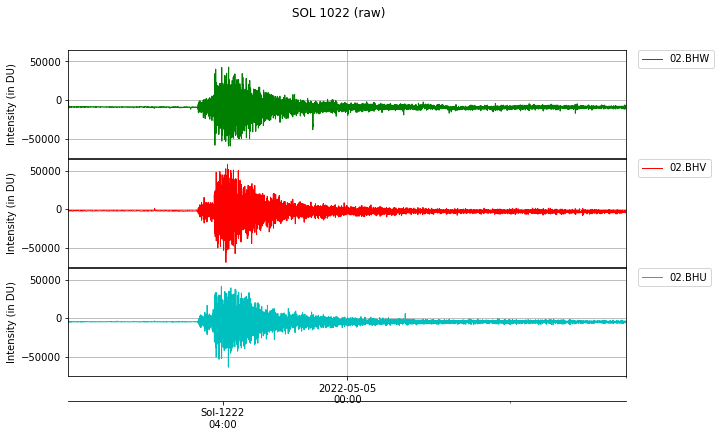

XB.ELYSE.02.BHU | 2022-05-04T23:00:00.019000Z - 2022-05-05T01:00:00.019000Z | 20.0 Hz, 144001 samples
XB.ELYSE.02.BHV | 2022-05-04T23:00:00.020000Z - 2022-05-05T01:00:00.020000Z | 20.0 Hz, 144001 samples
XB.ELYSE.02.BHW | 2022-05-04T23:00:00.019000Z - 2022-05-05T01:00:00.019000Z | 20.0 Hz, 144001 samples


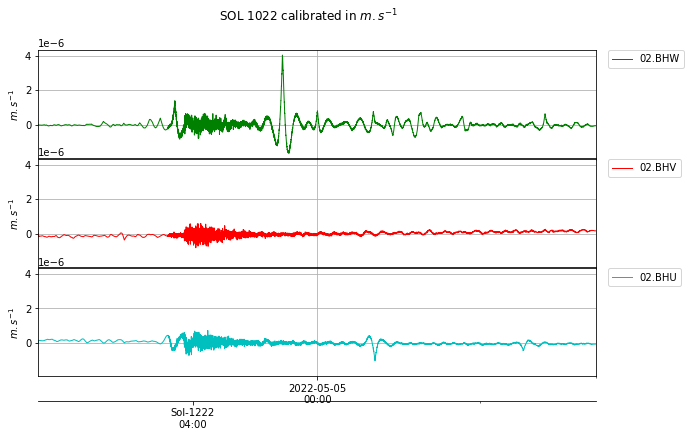

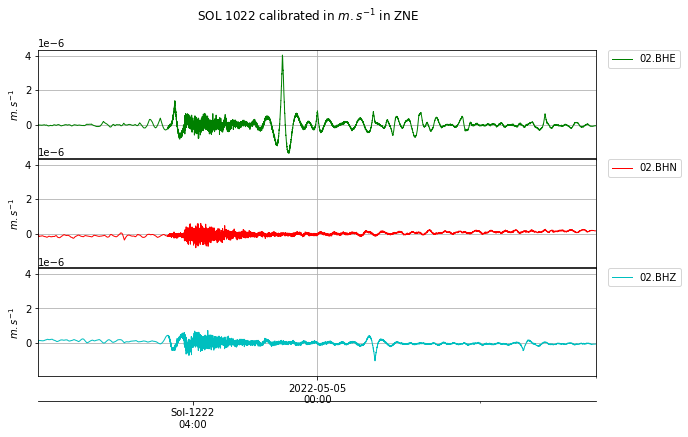

-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.




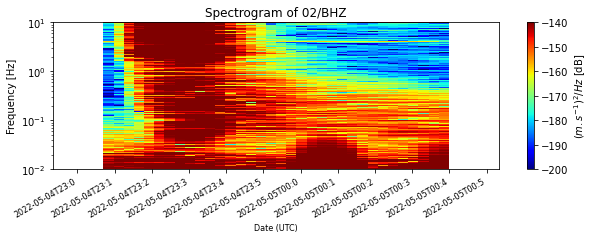

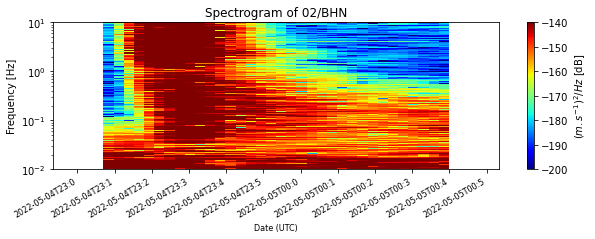

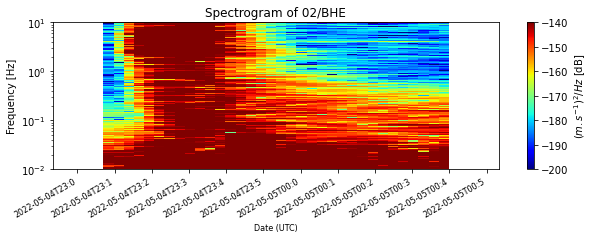

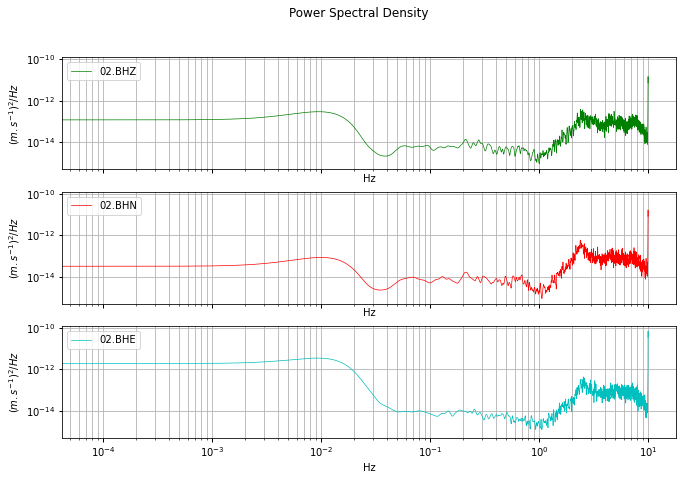

In [6]:
%run SEIS_calib_data.py